# Pratical Assignment

### Building a SVM from 'scratch'

The following implementation of the SVM algorithm to be used in this very assignment was adapted from the book *Machine Learning: An Algorithm Perspective* by Stephen Marsland.
We set out to firstly test the implementation using the Iris dataset. 

In [204]:
#import section
import pandas as pd
import os
import importlib
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import SVM
importlib.reload(SVM)
from SVM import svm,getPut,target_normalization,sequence, score, err_min_cls,plotD, tuning
from sklearn.metrics import accuracy_score


In [205]:
#reading the csv
# os.chdir('datasets')
df_3=pd.read_csv('iris.data')
enc = LabelEncoder()
df_3['class'] = enc.fit_transform(df_3['class'])
df=df_3.to_numpy()

13 support vectors found
27 support vectors found
26 support vectors found


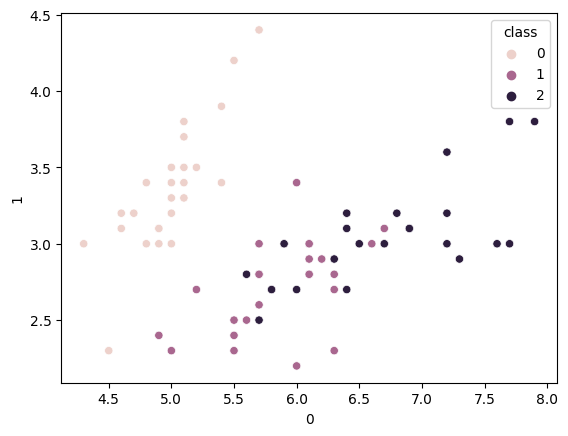

In [206]:
y_pred,y_test,x_test=sequence(df,n_class=3,k='rbf')
y_pred=getPut(y_pred)
y_test=getPut(y_test)
plotD(x_test,y_pred,0,1)

In the previous steps we loaded the dataset, converted it to fit the model, splitted the set into train and test sets, trained the model and also predicted the test target values.

After deep algorithmic analyisis, getting to understand the implementation and designing functions to integrate the SVM into the assignment's pipeline, we thought of tackling condensed distributions using techniques usually applied to imbalanced domain classification.

Note: the functions and methods used for both the scikitlearn support vector classifier and our own are defined in a separate python files (in the same directory) which we import to this notebook. Therefore, to understand the inner workings of the algorithm it is suggested to analyse these files as the notebook is more focused on abstracting the task and therefore only displays the results. 

### Dataset Selection, Visualization and Initial Assessment

An initial visualization of the data distribution will allow us to better understand the class separations and decision boundaries but most importantly see if they fit the desired characteristics. We utilize a scatter plot to check possible decision boundaries and overlapping and a correlation matrix to analyse which attributes are relevant to the classifier. Furthermore, we copy the raw dataframes into new replacemente frames on which we can do modification, such as dropping missing values, slicing, etc.

#### Blood Transfusion Service Center

In [207]:
df_blood = pd.read_csv('blood.csv')
df_blood.head()

,V1,V2,V3,V4,Class
0,2.0,50.0,12500.0,98.0,b'2'
1,0.0,13.0,3250.0,28.0,b'2'
2,1.0,16.0,4000.0,35.0,b'2'
3,2.0,20.0,5000.0,45.0,b'2'
4,1.0,24.0,6000.0,77.0,b'1'


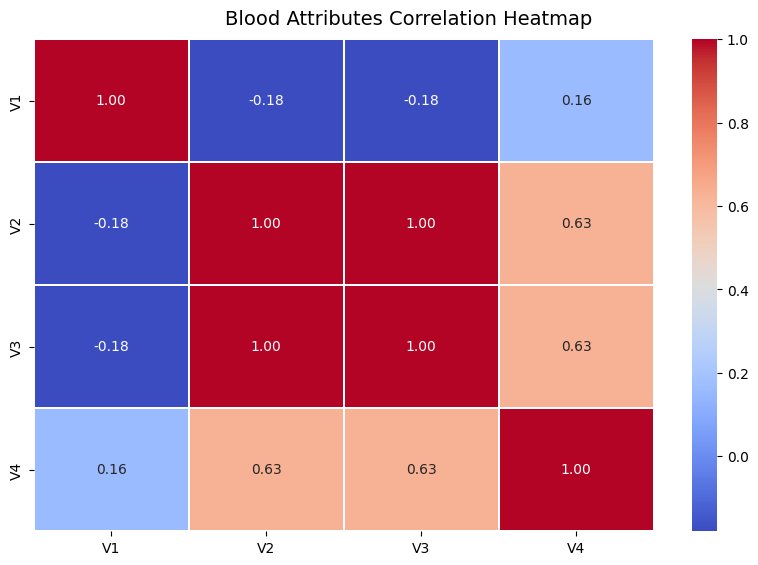

In [208]:
#plotting the correlattion matrix in order to find possible irrelevant attributes
f, ax = plt.subplots(figsize=(10, 6))
corr = df_blood.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Blood Attributes Correlation Heatmap', fontsize=14)

<AxesSubplot:xlabel='V1', ylabel='V4'>

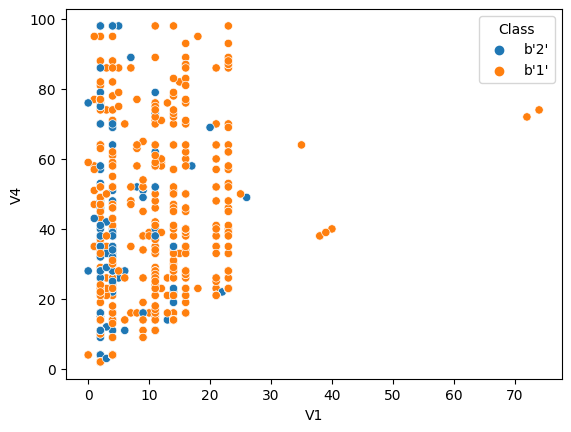

In [209]:
# devemos usar Scaler? que conclusões tirar do scatterplot
sns.scatterplot(data=df_blood, x='V1', y='V4', hue='Class')

In [210]:
#we create a new dataframe to which we will make the necessary modifications

df_blood_replaced = df_blood.copy(deep=True)
df_blood_replaced.dropna(0, inplace=True)
df_blood_replaced.info

C:\Users\admin\AppData\Local\Temp\ipykernel_4940\1893863980.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df_blood_replaced.dropna(0, inplace=True)


<bound method DataFrame.info of        V1    V2       V3    V4 Class
0     2.0  50.0  12500.0  98.0  b'2'
1     0.0  13.0   3250.0  28.0  b'2'
2     1.0  16.0   4000.0  35.0  b'2'
3     2.0  20.0   5000.0  45.0  b'2'
4     1.0  24.0   6000.0  77.0  b'1'
..    ...   ...      ...   ...   ...
743  23.0   2.0    500.0  38.0  b'1'
744  21.0   2.0    500.0  52.0  b'1'
745  23.0   3.0    750.0  62.0  b'1'
746  39.0   1.0    250.0  39.0  b'1'
747  72.0   1.0    250.0  72.0  b'1'

[748 rows x 5 columns]>

In [211]:
df_blood_replaced.Class.replace({"b'2'":1, "b'1'":0}, inplace=True)
predictors_blood = df_blood_replaced.drop('Class', axis=1)
target_blood = df_blood_replaced.Class

#### Diabetes Patients 

In [212]:
df_diabetes = pd.read_csv('diabetes.csv')

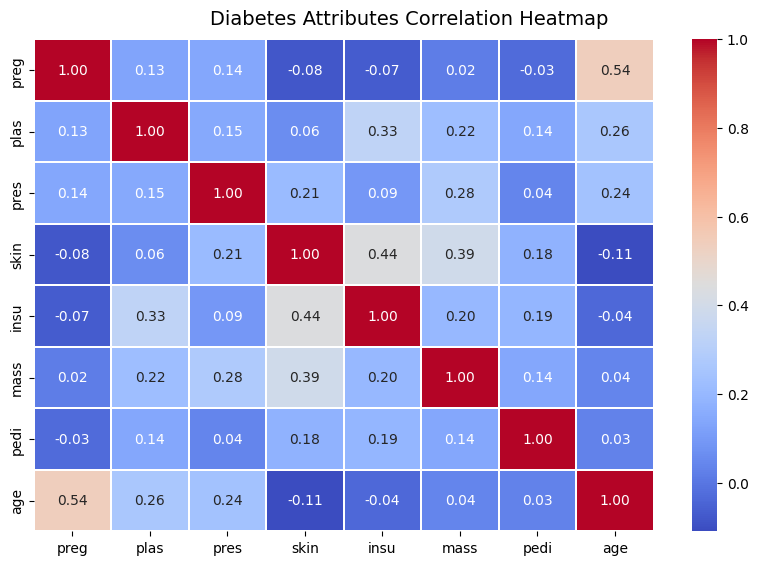

In [213]:
f, ax = plt.subplots(figsize=(10, 6))
corr = df_diabetes.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Diabetes Attributes Correlation Heatmap', fontsize=14)

<AxesSubplot:xlabel='plas', ylabel='pedi'>

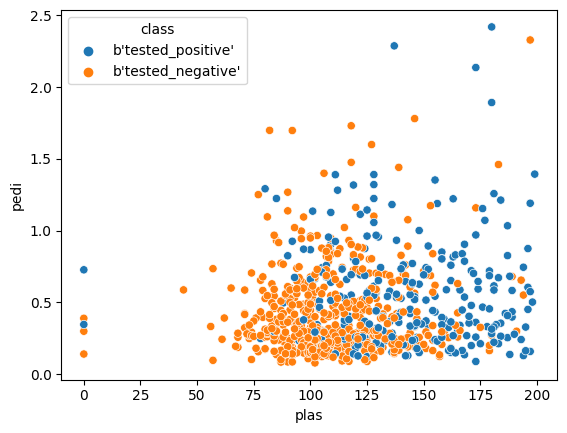

In [214]:
#from this scatterplot we can visualize the overlapping of the datapoints
sns.scatterplot(data=df_diabetes, x='plas', y='pedi', hue='class')

In [215]:
df_diabetes_replaced = df_diabetes.copy(deep=True)
df_diabetes_replaced.dropna(0, inplace=True)
df_diabetes_replaced.info

C:\Users\admin\AppData\Local\Temp\ipykernel_4940\2038734512.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df_diabetes_replaced.dropna(0, inplace=True)


<bound method DataFrame.info of      preg   plas  pres  skin   insu  mass   pedi   age               class
0     6.0  148.0  72.0  35.0    0.0  33.6  0.627  50.0  b'tested_positive'
1     1.0   85.0  66.0  29.0    0.0  26.6  0.351  31.0  b'tested_negative'
2     8.0  183.0  64.0   0.0    0.0  23.3  0.672  32.0  b'tested_positive'
3     1.0   89.0  66.0  23.0   94.0  28.1  0.167  21.0  b'tested_negative'
4     0.0  137.0  40.0  35.0  168.0  43.1  2.288  33.0  b'tested_positive'
..    ...    ...   ...   ...    ...   ...    ...   ...                 ...
763  10.0  101.0  76.0  48.0  180.0  32.9  0.171  63.0  b'tested_negative'
764   2.0  122.0  70.0  27.0    0.0  36.8  0.340  27.0  b'tested_negative'
765   5.0  121.0  72.0  23.0  112.0  26.2  0.245  30.0  b'tested_negative'
766   1.0  126.0  60.0   0.0    0.0  30.1  0.349  47.0  b'tested_positive'
767   1.0   93.0  70.0  31.0    0.0  30.4  0.315  23.0  b'tested_negative'

[768 rows x 9 columns]>

In [216]:
df_diabetes_replaced['class'].replace({"b'tested_negative'":0, "b'tested_positive'":1}, inplace=True)
predictors_diabetes = df_diabetes_replaced.drop('class', axis=1)
target_diabetes = df_diabetes_replaced['class']

#### Breast Diagnosis

In [217]:
df_breast = pd.read_csv('breast-w.csv')
df_breast.head()

,Clump_Thickness,Cell_Size_Uniformity,Cell_Shape_Uniformity,Marginal_Adhesion,Single_Epi_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,b'benign'
1,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1.0,b'benign'
2,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,b'benign'
3,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0,b'benign'
4,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0,b'benign'


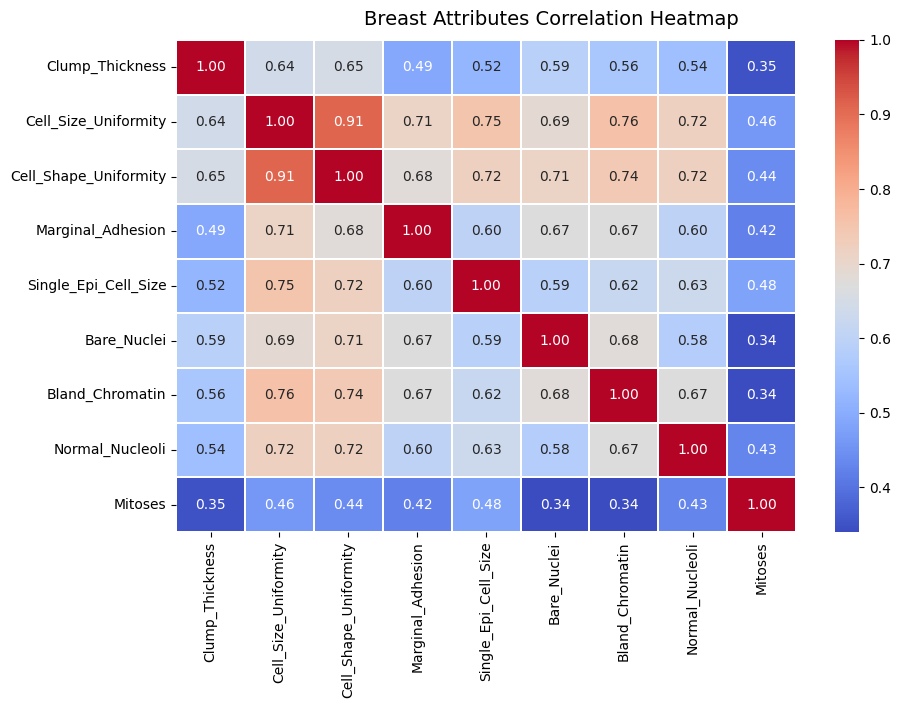

In [218]:
f, ax = plt.subplots(figsize=(10, 6))
corr = df_breast.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Breast Attributes Correlation Heatmap', fontsize=14)

<AxesSubplot:xlabel='Bare_Nuclei', ylabel='Normal_Nucleoli'>

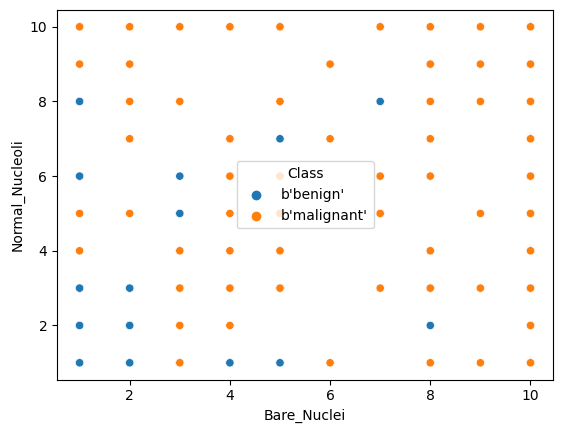

In [219]:
sns.scatterplot(data=df_breast, x='Bare_Nuclei', y='Normal_Nucleoli', hue='Class')

In [220]:
df_breast_replaced = df_breast.copy(deep=True)
df_breast_replaced.dropna(0, inplace=True)
df_breast_replaced.info

C:\Users\admin\AppData\Local\Temp\ipykernel_4940\1607264459.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df_breast_replaced.dropna(0, inplace=True)


<bound method DataFrame.info of      Clump_Thickness  Cell_Size_Uniformity  Cell_Shape_Uniformity  \
0                5.0                   1.0                    1.0   
1                5.0                   4.0                    4.0   
2                3.0                   1.0                    1.0   
3                6.0                   8.0                    8.0   
4                4.0                   1.0                    1.0   
..               ...                   ...                    ...   
694              3.0                   1.0                    1.0   
695              2.0                   1.0                    1.0   
696              5.0                  10.0                   10.0   
697              4.0                   8.0                    6.0   
698              4.0                   8.0                    8.0   

     Marginal_Adhesion  Single_Epi_Cell_Size  Bare_Nuclei  Bland_Chromatin  \
0                  1.0                   2.0          1.0    

In [231]:
df_breast_replaced['Class'].replace({"b'benign'":0, "b'malignant'":1}, inplace=True)
predictors_breast = df_breast_replaced.drop('Class', axis=1)
target_breast = df_breast_replaced['Class']

0         b'benign'
1         b'benign'
2         b'benign'
3         b'benign'
4         b'benign'
           ...     
694       b'benign'
695       b'benign'
696    b'malignant'
697    b'malignant'
698    b'malignant'
Name: Class, Length: 683, dtype: object

### Applying the ScikitLearn Classifier

We will now apply the standard Support Vector Classifier from the scikit-learn module to each dataset. From this we can understand the behavior of the model and compare it with our own.

For each dataset, we feed the model a 2-dimensional predictors frame (the attributes selected based on the results showed earlier) and the corresponding target frame. First, we apply holdout estimation to evaluate the behavior of different kernels, plotting the decision boundary of each classification. Secondly, we tune the hyperparameters to yield the best possible accuracy and plot this decision boundary as well.

In [222]:
import sklearn_svm
importlib.reload(sklearn_svm)

sklearn_svm.check_params()

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


#### BTSC Dataset

In [223]:
predictors_blood_trunc = predictors_blood[['V1', 'V4']]
predictors_blood_trunc

,V1,V4
0,2.0,98.0
1,0.0,28.0
2,1.0,35.0
3,2.0,45.0
4,1.0,77.0
...,...,...
743,23.0,38.0
744,21.0,52.0
745,23.0,62.0
746,39.0,39.0


linear kernel
Accuracy: 0.729


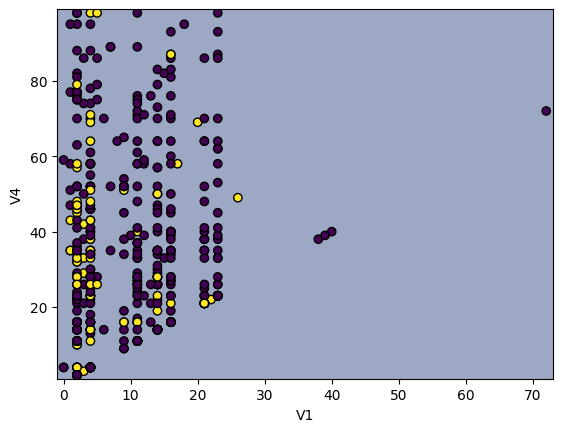

poly kernel
Accuracy: 0.729


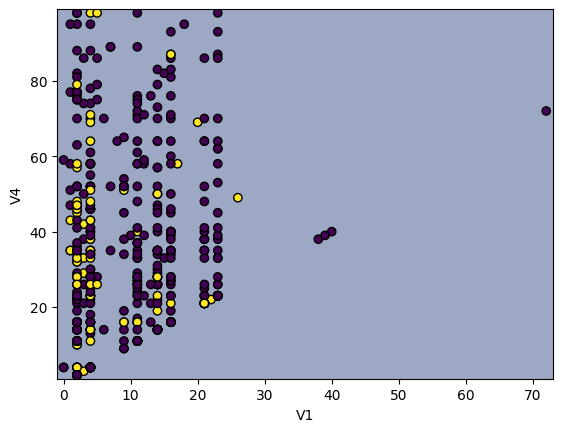

rbf kernel
Accuracy: 0.729


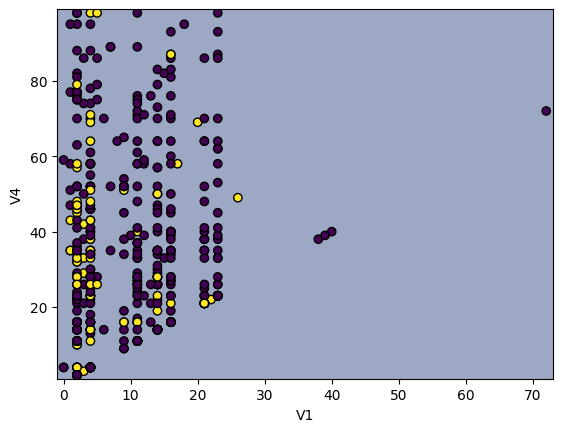

In [224]:
sklearn_svm.holdout_estimation(predictors_blood_trunc, target_blood, 'V1', 'V4')

#### Diabetes Dataset

In [225]:
predictors_diabetes_trunc = predictors_diabetes[['plas', 'pedi']]
predictors_diabetes_trunc

,plas,pedi
0,148.0,0.627
1,85.0,0.351
2,183.0,0.672
3,89.0,0.167
4,137.0,2.288
...,...,...
763,101.0,0.171
764,122.0,0.340
765,121.0,0.245
766,126.0,0.349


linear kernel
Accuracy: 0.758


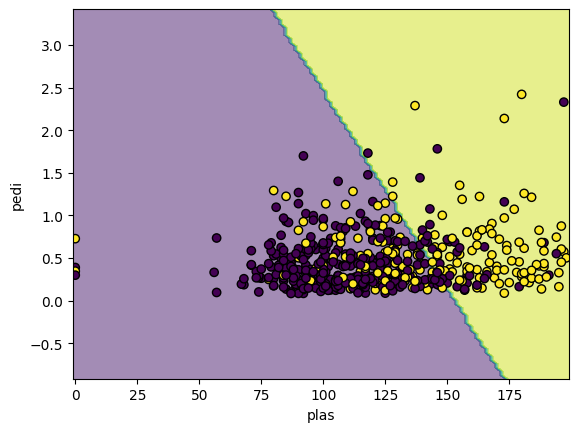

poly kernel
Accuracy: 0.736


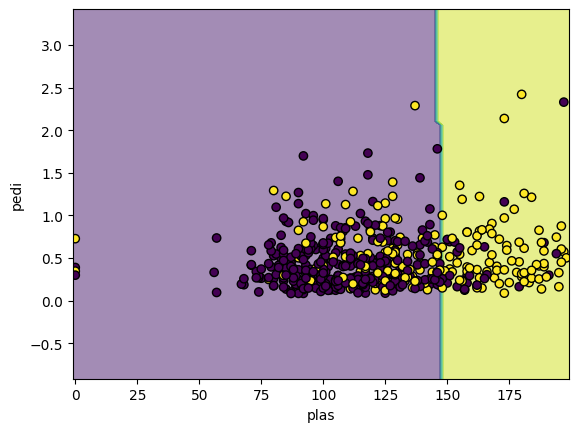

rbf kernel
Accuracy: 0.736


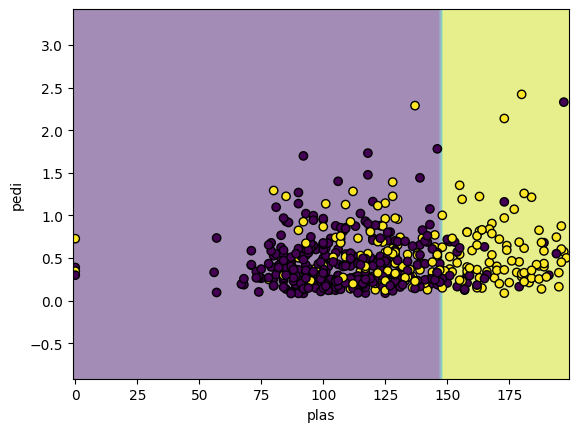

In [226]:
sklearn_svm.holdout_estimation(predictors_diabetes_trunc, target_diabetes, 'plas', 'pedi')

Chosen parameters: {'C': 1, 'degree': 1, 'kernel': 'poly'}
Accuracy: 0.740


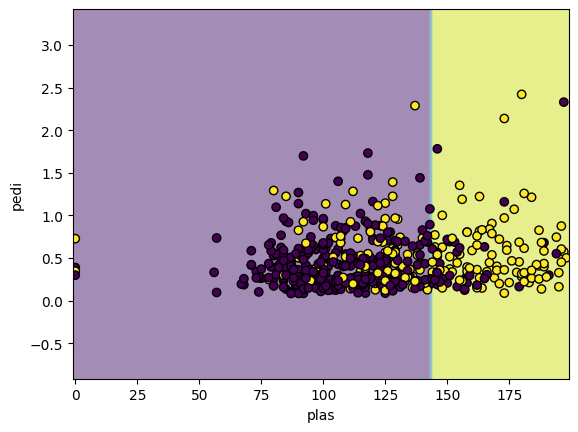

In [227]:
sklearn_svm.tuning(predictors_diabetes_trunc, target_diabetes, 'plas', 'pedi')

#### Breast Dataset

In [228]:
predictors_breast_trunc = predictors_breast[['Bare_Nuclei', 'Normal_Nucleoli']]
predictors_breast_trunc

,Bare_Nuclei,Normal_Nucleoli
0,1.0,1.0
1,10.0,2.0
2,2.0,1.0
3,4.0,7.0
4,1.0,1.0
...,...,...
694,2.0,1.0
695,1.0,1.0
696,3.0,10.0
697,4.0,6.0


linear kernel
Accuracy: 0.922


ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not 111    b'malignant'
492       b'benign'
211    b'malignant'
332       b'benign'
196       b'benign'
           ...     
9         b'benign'
373       b'benign'
198       b'benign'
645       b'benign'
574    b'malignant'
Name: Class, Length: 478, dtype: object

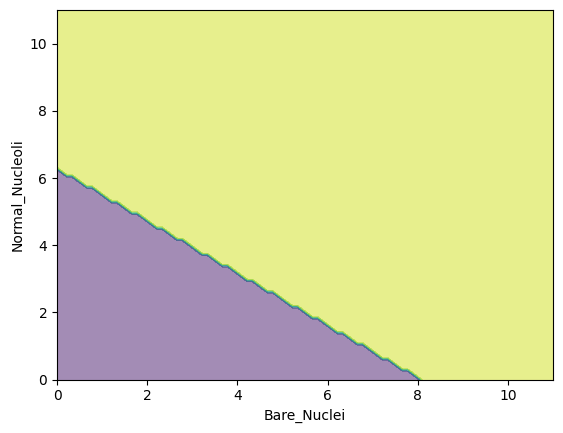

In [230]:
sklearn_svm.holdout_estimation(predictors_breast_trunc, target_breast, 'Bare_Nuclei', 'Normal_Nucleoli')

Chosen parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy: 0.937


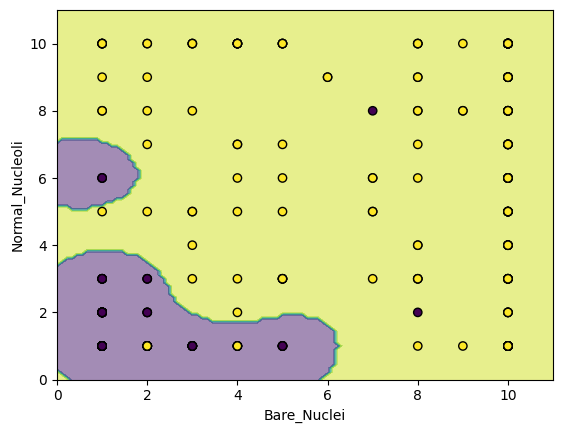

In [ ]:
sklearn_svm.tuning(predictors_breast_trunc, target_breast, 'Bare_Nuclei', 'Normal_Nucleoli')

###  Our Implementation

We will now attempt classification on the same datasets but using the classifier from our own Support Vector Machine (you can find the full implementation in SVM.py). Just like with the sklearn module, we start by using the default hyperparameters and progressively analyse and tune the model's behavior. However, in this classifier, we also apply a custom modification in the algorithm specifically targeted to better handle the misclassification of the minority class.

As input for our model we use a dataframe consisting of the previous already treated combinations of predictors and target for each dataset. Due to the particular way the SVM learns, it receives the whole dataframe, internally splitting the data and using the relevant (datapoint, label) pairs to train the machine. The function we call then returns the algorithms' prediction and the true labeling, so we can measure the performance.

For each dataset, we first apply the model with an rbf kernel. Secondly, we tune the hyperparameters over the polynomial kernel in an attempt to find a better classifier. Thirdly, we classify with a new model that implements the custom modification we discussed and evaluate if this modification shows a significant change.


##### BTSC Dataset

In [ ]:
dfb=pd.concat([predictors_blood_trunc, target_blood], axis=1).to_numpy()
dfb

array([[ 2., 98.,  1.],
       [ 0., 28.,  1.],
       [ 1., 35.,  1.],
       ...,
       [23., 62.,  0.],
       [39., 39.,  0.],
       [72., 72.,  0.]])

In [ ]:
by_pred,by_test,bx_test=sequence(dfb,k='rbf')

356 support vectors found
356 support vectors found


In [ ]:
score(by_test, by_pred)

accuracy: 0.687


Minority Class Misclassification

In [ ]:
err_min_cls(by_test, by_pred)

Misslabeled minority class examples:  46


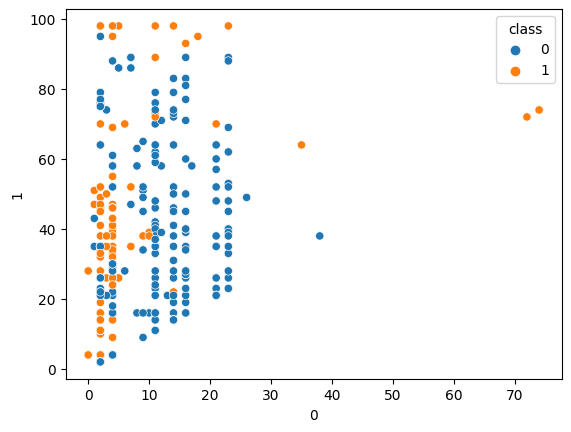

In [ ]:
plotD(bx_test,getPut(by_pred))

In [ ]:
tuning(dfb)

374 support vectors found
374 support vectors found
374 support vectors found
374 support vectors found
374 support vectors found
374 support vectors found
374 support vectors found
374 support vectors found
374 support vectors found
374 support vectors found
374 support vectors found
374 support vectors found
best parameter combination found:  {'kernel': 'poly', 'C': 0.1, 'sigma': 0.5, 'degree': 1, 'threshold': 0.0001}
accuracy: 0.781
Misslabeled minority class examples:  80


Contrary to the sklearn classifier which classified all instances as 0 (as shwon on DecisionBoundaryDisplay) our SVM already shows distinction between the two classes

##### Modified SVM

In [ ]:
C=[0.1,10]
mby_pred,mby_test,mbx_test=sequence(dfb,k='rbf',c_=C,wc=True)

358 support vectors found
341 support vectors found


In [ ]:
print(mby_pred)

[[-3.16527663e-02 -1.62987421e-01]
 [-1.28772494e-02 -7.28588447e-01]
 [ 3.20830679e-02 -3.20825820e-01]
 [ 1.03783150e-02  1.67917427e+00]
 [-8.84361927e-02  1.08155500e+00]
 [-2.76209838e-02  2.88072142e-01]
 [-4.74737122e-02  1.02575281e+00]
 [-3.55504790e-01  1.67917425e+00]
 [-2.95136110e-02 -3.20825740e-01]
 [-7.69169692e-02  1.67917418e+00]
 [ 3.20811793e-02 -3.20825738e-01]
 [-2.93689535e-01  1.67917418e+00]
 [-8.59876643e-02 -3.20825880e-01]
 [-1.26241938e-01  1.67917418e+00]
 [ 1.15529807e-02 -1.20871732e-01]
 [ 3.20811793e-02 -3.20825738e-01]
 [-8.16864893e-02  1.67917451e+00]
 [-8.95915527e-02  1.67917421e+00]
 [-3.89861665e-02 -3.20825652e-01]
 [ 1.93071076e-02 -1.88853609e-01]
 [-2.93689535e-01  1.67917418e+00]
 [-2.93689535e-01  1.67917418e+00]
 [ 3.20811793e-02 -3.20825738e-01]
 [ 3.20834642e-02 -3.20825856e-01]
 [ 3.20834642e-02 -3.20825856e-01]
 [-6.76027843e-02  2.99366734e-01]
 [-1.34011706e-01  1.67917426e+00]
 [-2.06731144e-01  1.67917436e+00]
 [-8.95915527e-02  1

As we can observe, after defining a larger weight for the minority class (1), the classification values attributed to the 1 class have a higher positive amplitude, so the alteration is taking effect

In [ ]:
score(mby_test, mby_pred)

accuracy: 0.668


In [ ]:
err_min_cls(mby_test, mby_pred)

Misslabeled minority class examples:  48


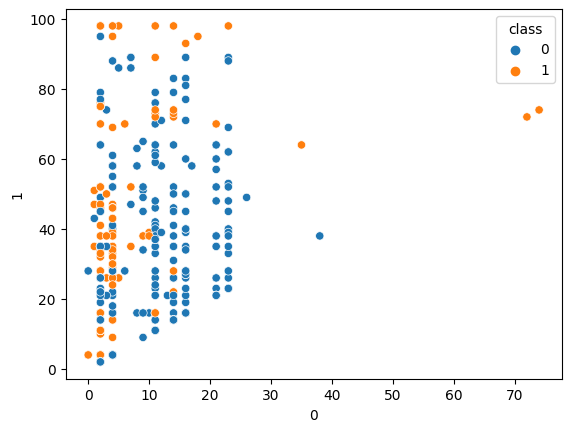

In [ ]:
plotD(mbx_test,getPut(mby_pred))

Even though the changes took effect, they didn't do anything at all for this dataset, unfortunately

#### Diabetes Patients Dataset

In [ ]:
dfd=pd.concat([predictors_diabetes_trunc, target_diabetes], axis=1).to_numpy()
dfd

array([[148.   ,   0.627,   1.   ],
       [ 85.   ,   0.351,   0.   ],
       [183.   ,   0.672,   1.   ],
       ...,
       [121.   ,   0.245,   0.   ],
       [126.   ,   0.349,   1.   ],
       [ 93.   ,   0.315,   0.   ]])

In [ ]:
dy_pred,dy_true,dx_test=sequence(dfd,k='rbf')

300 support vectors found
300 support vectors found


In [ ]:
score(dy_true, dy_pred)

accuracy: 0.737


In [ ]:
err_min_cls(dy_true, dy_pred)

Misslabeled minority class examples:  73


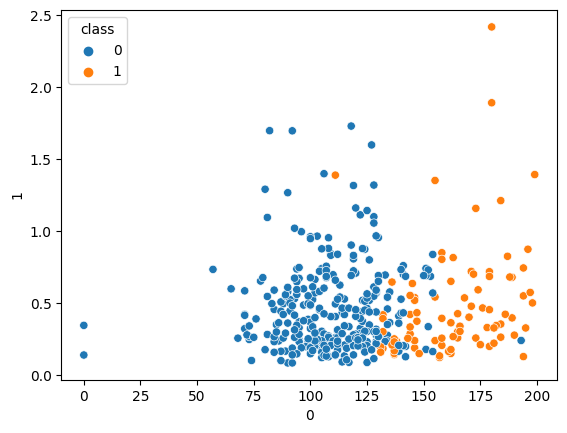

In [ ]:
plotD(dx_test,getPut(dy_pred))

In [ ]:
tuning(dfd, max_iters=15)

232 support vectors found
232 support vectors found
232 support vectors found
232 support vectors found
232 support vectors found
232 support vectors found
226 support vectors found
226 support vectors found
226 support vectors found
226 support vectors found
226 support vectors found
226 support vectors found
384 support vectors found
384 support vectors found
384 support vectors found
384 support vectors found
384 support vectors found
384 support vectors found
232 support vectors found
232 support vectors found
232 support vectors found
232 support vectors found
232 support vectors found
232 support vectors found
226 support vectors found
226 support vectors found
226 support vectors found
226 support vectors found
226 support vectors found
226 support vectors found
384 support vectors found
384 support vectors found
best parameter combination found:  {'kernel': 'poly', 'C': 0.1, 'sigma': 0.5, 'degree': 3, 'threshold': 0.0001}
accuracy: 0.630
Misslabeled minority class examples:  16

##### Modified SVM

In [ ]:
#passar atributos relevantes
C=[0.1,10]
mdy_pred,mdy_test,mdx_test=sequence(dfd,k='rbf',c_=C,wc=True)

300 support vectors found
281 support vectors found


In [ ]:
score(mdy_test, mdy_pred)

accuracy: 0.688


In [ ]:
err_min_cls(mdy_test, mdy_pred)

Misslabeled minority class examples:  73


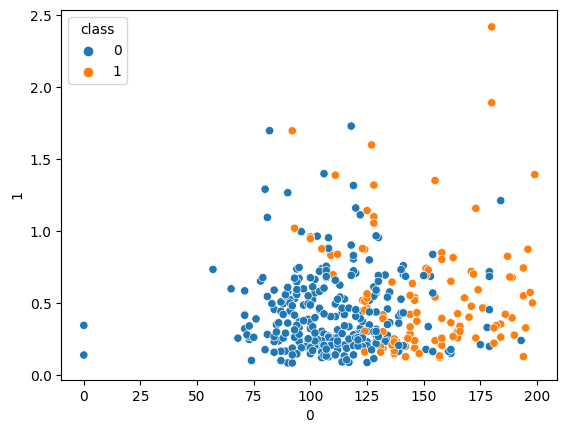

In [ ]:
plotD(mdx_test,getPut(mdy_pred))

##### Breast Diagnosis Dataset

In [ ]:
dfw=pd.concat([predictors_breast_trunc, target_breast], axis=1).to_numpy()
dfw

array([[ 1.,  1.,  0.],
       [10.,  2.,  0.],
       [ 2.,  1.,  0.],
       ...,
       [ 3., 10.,  1.],
       [ 4.,  6.,  1.],
       [ 5.,  4.,  1.]])

In [ ]:
wy_pred,wy_true,wx_test=sequence(dfw,k='rbf')

296 support vectors found
296 support vectors found


In [ ]:
score(wy_true, wy_pred)

accuracy: 0.941


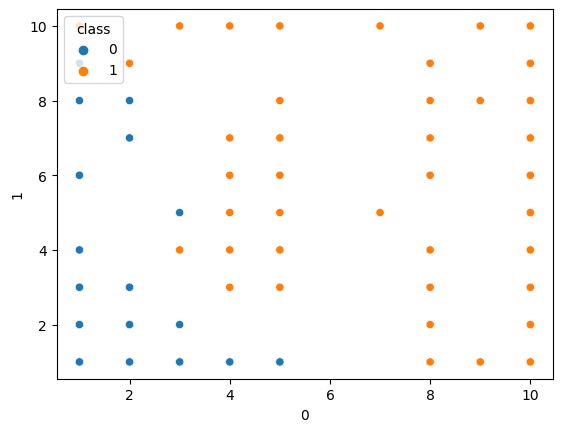

In [ ]:
plotD(wx_test,getPut(wy_pred))

In [ ]:
tuning(dfw, max_iters=20)

67 support vectors found
67 support vectors found
67 support vectors found
67 support vectors found
67 support vectors found
67 support vectors found
64 support vectors found
64 support vectors found
64 support vectors found
64 support vectors found
64 support vectors found
64 support vectors found
61 support vectors found
61 support vectors found
61 support vectors found
61 support vectors found
61 support vectors found
61 support vectors found
67 support vectors found
67 support vectors found
67 support vectors found
67 support vectors found
67 support vectors found
67 support vectors found
64 support vectors found
64 support vectors found
64 support vectors found
64 support vectors found
64 support vectors found
64 support vectors found
61 support vectors found
61 support vectors found
61 support vectors found
61 support vectors found
61 support vectors found
61 support vectors found
67 support vectors found
67 support vectors found
67 support vectors found
67 support vectors found


#### Modified SVM application to Breast dataset

In [ ]:
C=[0.1,10]
mwy_pred,mwy_test,mwx_test=sequence(dfw,k='rbf',c_=C,wc=True)

325 support vectors found
86 support vectors found


In [ ]:
score(mwy_test, mwy_pred)

accuracy: 0.935


In [ ]:
err_min_cls(mwy_test, mwy_pred)

Misslabeled minority class examples:  17


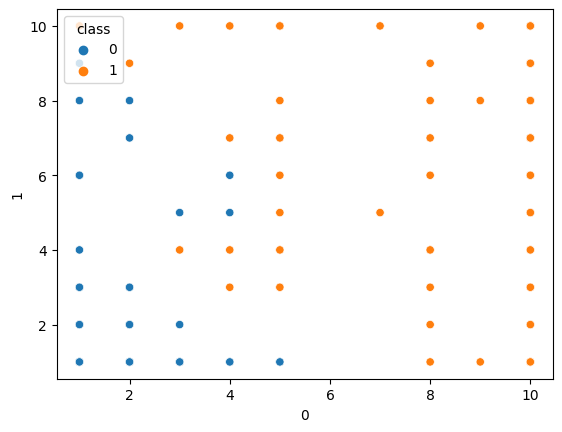

In [ ]:
plotD(mwx_test,getPut(mwy_pred))